In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from scipy import signal

In [2]:
## Load Dataset
templates = []

# 50 sec data
template_filename = '../recordings/first_target_' # {}.csv
train_data_filename = '../recordings/second_target_' # {}.csv

train_data = []

for i in range(0, 8):
    templates.append(pd.read_csv(template_filename+'{}.csv'.format(i), header=0))
    train_data.append(pd.read_csv(train_data_filename+'{}.csv'.format(i), header=0))

In [3]:
# cutoff according to shortest length
# only necessary if there is different lengths in the dataset
cutoff_list = [len(templates[i].index) for i in range(8)]
cutoff = min(cutoff_list)
for i in range(8):
    keep_indicies = set(range(templates[i].shape[0])) - set(range(cutoff, templates[i].shape[0]))
    templates[i] = templates[i].take(list(keep_indicies))
    print('length of dataset {} = {}'.format(i+1, len(templates[i].index)))
    
    keep_indicies = set(range(train_data[i].shape[0])) - set(range(cutoff, train_data[i].shape[0]))
    templates[i] = train_data[i].take(list(keep_indicies))
    print('2 length of dataset {} = {}'.format(i+1, len(train_data[i].index)))

length of dataset 1 = 6400
2 length of dataset 1 = 6400
length of dataset 2 = 6400
2 length of dataset 2 = 6400
length of dataset 3 = 6400
2 length of dataset 3 = 6400
length of dataset 4 = 6400
2 length of dataset 4 = 6400
length of dataset 5 = 6400
2 length of dataset 5 = 6400
length of dataset 6 = 6400
2 length of dataset 6 = 6400
length of dataset 7 = 6400
2 length of dataset 7 = 6400
length of dataset 8 = 6400
2 length of dataset 8 = 6400


In [4]:
def filter_template(template):
    new_temp = template
    channels = ['P7', 'O1', 'O2', 'P8']
    filt = signal.firwin(400, [.01, .06], pass_zero=False)
    #filt = signal.firwin(400, [8.0, 15.0], pass_zero=False, fs=128.0)
    for channel in channels:
        N = len(template.index)
        #new_temp[channel] = [f - np.average(np.array(template[channel])) for f in template[channel]]
        new_temp[channel] = signal.convolve(new_temp[channel], filt, mode='same')
    
    return new_temp

In [5]:
for template in templates:
    template = filter_template(template)
for train in train_data:
    train = filter_template(train)

In [6]:
def plot_time(template, xlim=1000):
    fig, (o1, o2, p7, p8) = plt.subplots(1, 4, figsize=(15,5))
    o1.plot(template['O1'])
    o1.set_title('O1')
    o1.set_xlim([0,xlim])
    o2.plot(template['O2'])
    o2.set_title('O2')
    o2.set_xlim([0,xlim])
    p7.plot(template['P7'])
    p7.set_title('P7')
    p7.set_xlim([0,xlim])
    p8.plot(template['P8'])
    p8.set_title('P8')
    p8.set_xlim([0,xlim])
    
    
    plt.show()

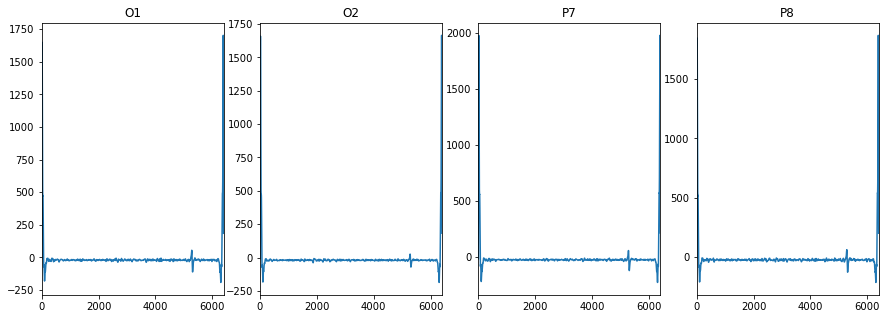

In [7]:
plot_time(templates[0], xlim=6400)

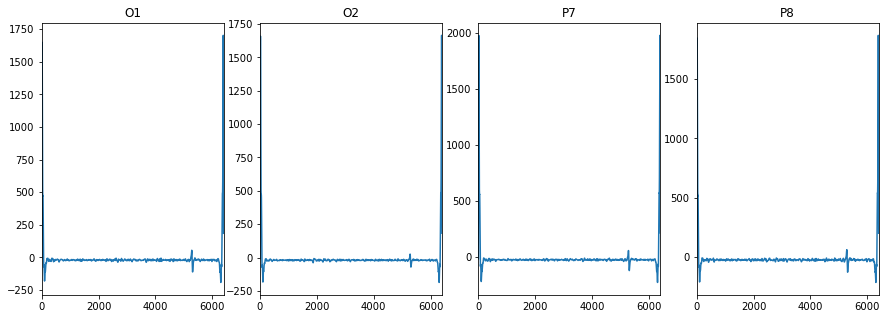

In [8]:
plot_time(train_data[0], xlim=6400)

In [9]:
# len(train_data)

In [10]:
for i in range(8):
    templates[i]['Unnamed: 0'] = [i % 129 for i in range(len(templates[i].index))]
    templates[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)
    
    train_data[i]['Unnamed: 0'] = [i % 129 for i in range(len(train_data[i].index))]
    train_data[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)

In [11]:
# train_data

In [12]:
# average for each same EEG.Counter number - over all stimulus cycles
averages_all_targets = []

for template in templates:
    averages_for_target = []
    o1counters = []
    o2counters = []
    p7counters = []
    p8counters = []
    for i in range(129):
        o1counters.append([])
        o2counters.append([])
        p7counters.append([])
        p8counters.append([])
        
    for ind, row in template.iterrows():
        count_val = int(row['Counter'])
        #print(count_val)
        o1counters[count_val].append(row['O1'])
        o2counters[count_val].append(row['O2'])
        p7counters[count_val].append(row['P7'])
        p8counters[count_val].append(row['P8'])
    
    for i in range(129):
        # find average for each counter value
        o1avg = np.average(np.array(o1counters[i]))
        o2avg = np.average(np.array(o2counters[i]))
        p7avg = np.average(np.array(p7counters[i]))
        p8avg = np.average(np.array(p8counters[i]))
        row = {'Counter': i, 'O1': o1avg, 'O2': o2avg, 'P7': p7avg, 'P8': p8avg}
        averages_for_target.append(row)
        
    averages_all_targets.append(pd.DataFrame(data=averages_for_target))
    # 129 length averages

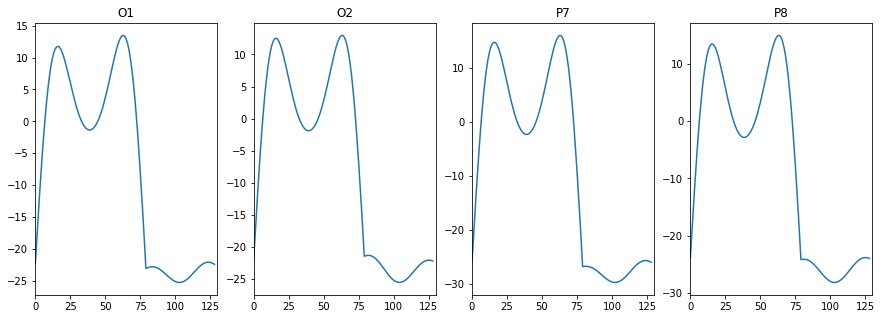

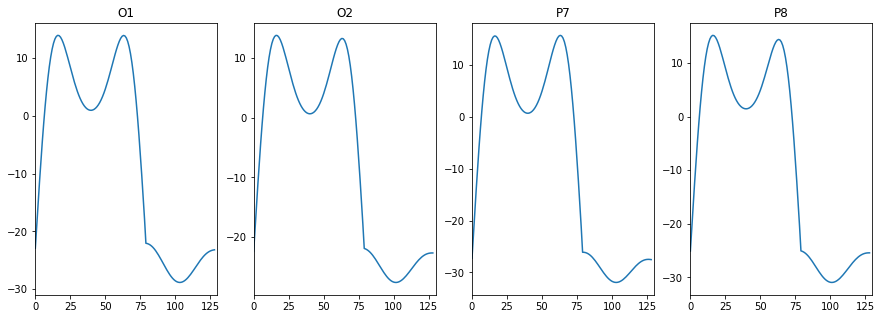

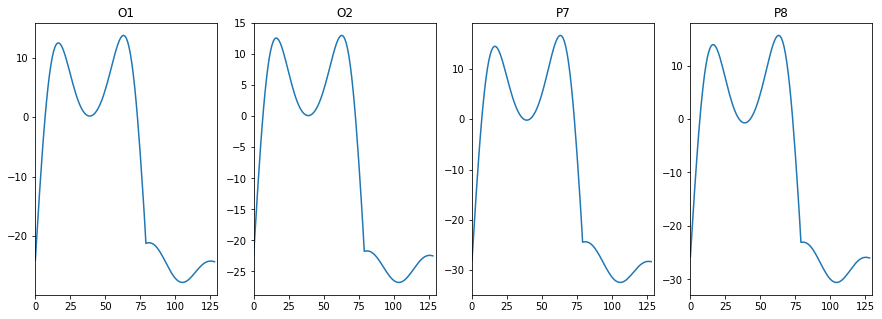

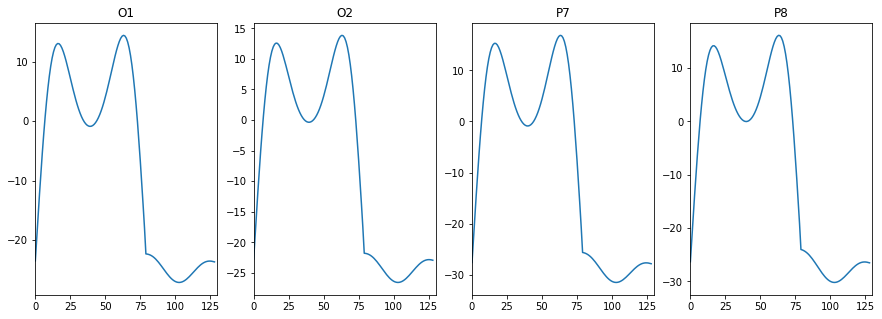

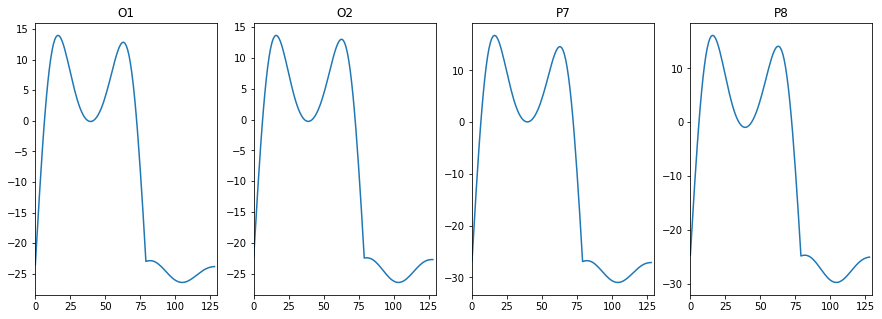

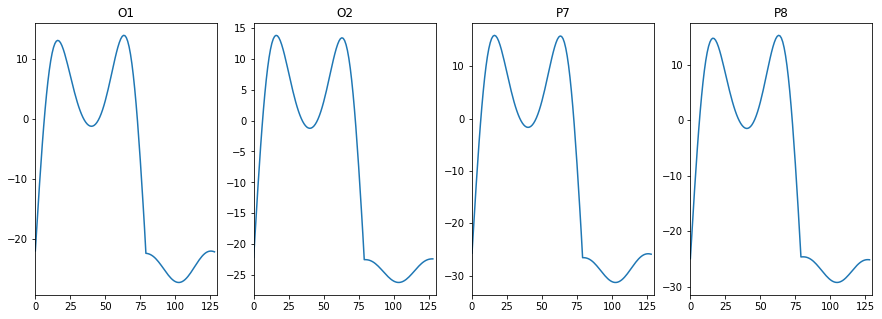

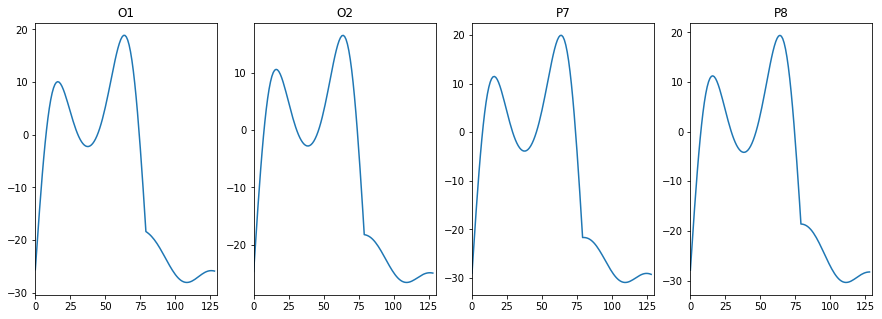

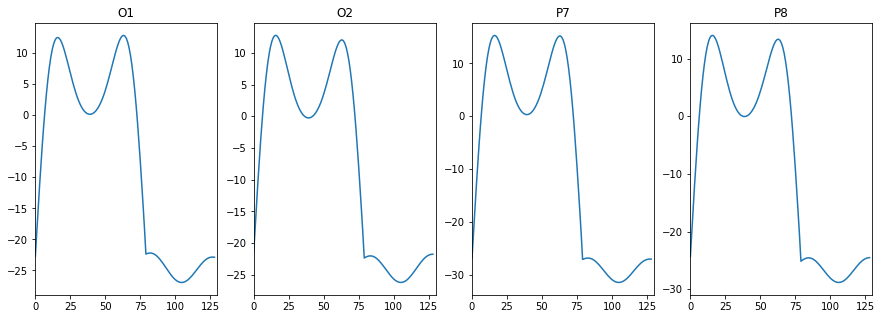

In [13]:
for sig in averages_all_targets:
    plot_time(sig, xlim=130)

In [14]:
# correlations
# take 1s - 128 samples of template[0] and correlate with each average in average_all_targets
from scipy.stats.stats import pearsonr

def signal_correlation(test_signals, verbose=False):
    # assume I have all averages
    corrs_o1 = []
    corrs_o2 = []
    corrs_p7 = []
    corrs_p8 = []
    for ref in averages_all_targets:
        # pearsonr returns r (corr value) and p-value
        corr_o1 = pearsonr(np.array(test_signals['O1']), np.array(ref['O1']))
        corr_o2 = pearsonr(np.array(test_signals['O2']), np.array(ref['O2']))
        corr_p7 = pearsonr(np.array(test_signals['P7']), np.array(ref['P7']))
        corr_p8 = pearsonr(np.array(test_signals['P8']), np.array(ref['P8']))
        corrs_o1.append(corr_o1[0])
        corrs_o2.append(corr_o2[0])
        corrs_p7.append(corr_p7[0])
        corrs_p8.append(corr_p8[0])

    targeto1 = corrs_o1.index(max(corrs_o1))
    targeto2 = corrs_o2.index(max(corrs_o2))
    targetp7 = corrs_p7.index(max(corrs_p7))
    targetp8 = corrs_p8.index(max(corrs_p8))
    
    if verbose:
        print('Correlation Data:\n{}\n{}\n{}\n{}\n'.format(corrs_o1, corrs_o2, corrs_p7, corrs_p8))

    return (targeto1, targeto2, targetp7, targetp8)


In [15]:
test1 = templates[0].query('index < 129')
# looking for target 0
to1, to2, tp7, tp8 = signal_correlation(test1)
print('targets: o1 : {}  o2 : {}   p7 : {}   p8 : {}'.format(to1, to2, tp7, tp8))

targets: o1 : 4  o2 : 7   p7 : 4   p8 : 4


In [16]:
test2 = templates[0].query('129 < index < 129*2+1')
# looking for target 0
to1, to2, tp7, tp8 = signal_correlation(test2)
print('targets: o1 : {}  o2 : {}   p7 : {}   p8 : {}'.format(to1, to2, tp7, tp8))

targets: o1 : 6  o2 : 6   p7 : 6   p8 : 6


In [17]:
test3 = templates[1].query('index < 129')
# looking for target 1 
to1, to2, tp7, tp8 = signal_correlation(test3)
print('targets: o1 : {}  o2 : {}   p7 : {}   p8 : {}'.format(to1, to2, tp7, tp8))

targets: o1 : 4  o2 : 7   p7 : 4   p8 : 4


In [18]:
test4 = templates[1].query('129 < index < 129*2+1')
# looking for target 1 
to1, to2, tp7, tp8 = signal_correlation(test4)
print('targets: o1 : {}  o2 : {}   p7 : {}   p8 : {}'.format(to1, to2, tp7, tp8))

targets: o1 : 6  o2 : 6   p7 : 6   p8 : 6


In [19]:
test5 = templates[1].query('129*2 < index < 129*3+1')
# looking for target 1 
to1, to2, tp7, tp8 = signal_correlation(test5)
print('targets: o1 : {}  o2 : {}   p7 : {}   p8 : {}'.format(to1, to2, tp7, tp8))

targets: o1 : 5  o2 : 0   p7 : 0   p8 : 0


In [21]:
# print(len(averages_all_targets), len(averages_all_targets[0]))
# print(len(train_data), len(train_data[0]))
# # print('avg\n', averages_all_targets)
# # print('train\n', train_data)

# channels = ['O1', 'O2', 'P7', 'P8']
# a = np.array([averages_all_targets[i][channels] for i in range(8)])
# b = np.array([train_data[i][channels] for i in range(8)])

In [22]:
#Chris testing CCA implementation
from sklearn.cross_decomposition import CCA

#print(averages_all_targets[0])
#print(train_data[0])

channels = ['O1', 'O2', 'P7', 'P8']
a = np.array([averages_all_targets[i][channels] for i in range(8)])
b = np.array([train_data[i][channels] for i in range(8)])
#print(b[0][130])
#print(a[1][0])

target_data_array = []
train_data_array = []

for i in a:
    for j in i:
        target_data_array.append(np.delete(j, 0, None))
        #print(target_data_array[len(target_data_array)-1]) 

        
for n in b:
    for m in n:
        train_data_array.append(np.delete(m, 0, None))
#print(len(train_data_array))
        
num_seconds = int(len(train_data[0]) / (len(averages_all_targets[0]) - 1))

y_input = []

y_vals = [[] for t in range(8)]
x_vals = [[] for t in range(8)]

itr1 = 0
for k in range(len(averages_all_targets)):
    for u in a[k]:
        y_vals[k].append(np.delete(u, 0, None))
    for v in b[k]:
        x_vals[k].append(np.delete(v, 0, None))
        
    for l in range(num_seconds):
        for r in target_data_array[itr1:itr1+129]:
            y_input.append(r)
            #print(r)
        del y_input[-1]
    itr1 = itr1 + 129


#print(y_vals[0])
#print(x_vals[0])
# print(train_data_array[4])
# print(train_data[0])
# print(len(y_input))
# print(y_input[128])
# print(y_input[129])
# print(y_input[0])
# print(y_input[130])

cca = CCA(n_components=1)

cca.fit(train_data_array, y_input)
print(train_data_array[0])
values_x, values_y = cca.transform(train_data_array, y_input)
print(train_data_array[0])
print("x:", values_x)
print("y:", values_y)
print(cca.score(train_data_array[0:129], y_input[0:129], values_y[0:129]))


print("0")
print(cca.score(x_vals[0][0:129], y_vals[0]))
print(cca.score(x_vals[0][0:129], y_vals[1]))
print(cca.score(x_vals[0][0:129], y_vals[2]))
print(cca.score(x_vals[0][0:129], y_vals[3]))
print(cca.score(x_vals[0][0:129], y_vals[4]))
print(cca.score(x_vals[0][0:129], y_vals[5]))
print(cca.score(x_vals[0][0:129], y_vals[6]))
print(cca.score(x_vals[0][0:129], y_vals[7]))
print("1")
print(cca.score(x_vals[1][0:129], y_vals[0]))
print(cca.score(x_vals[1][0:129], y_vals[1]))
print(cca.score(x_vals[1][0:129], y_vals[2]))
print(cca.score(x_vals[1][0:129], y_vals[3]))
print(cca.score(x_vals[1][0:129], y_vals[4]))
print(cca.score(x_vals[1][0:129], y_vals[5]))
print(cca.score(x_vals[1][0:129], y_vals[6]))
print(cca.score(x_vals[1][0:129], y_vals[7]))
print("2")
print(cca.score(x_vals[2][0:129], y_vals[0]))
print(cca.score(x_vals[2][0:129], y_vals[1]))
print(cca.score(x_vals[2][0:129], y_vals[2]))
print(cca.score(x_vals[2][0:129], y_vals[3]))
print(cca.score(x_vals[2][0:129], y_vals[4]))
print(cca.score(x_vals[2][0:129], y_vals[5]))
print(cca.score(x_vals[2][0:129], y_vals[6]))
print(cca.score(x_vals[2][0:129], y_vals[7]))
print("3")
print(cca.score(x_vals[3][0:129], y_vals[0]))
print(cca.score(x_vals[3][0:129], y_vals[1]))
print(cca.score(x_vals[3][0:129], y_vals[2]))
print(cca.score(x_vals[3][0:129], y_vals[3]))
print(cca.score(x_vals[3][0:129], y_vals[4]))
print(cca.score(x_vals[3][0:129], y_vals[5]))
print(cca.score(x_vals[3][0:129], y_vals[6]))
print(cca.score(x_vals[3][0:129], y_vals[7]))
print("4")
print(cca.score(x_vals[4][0:129], y_vals[0]))
print(cca.score(x_vals[4][0:129], y_vals[1]))
print(cca.score(x_vals[4][0:129], y_vals[2]))
print(cca.score(x_vals[4][0:129], y_vals[3]))
print(cca.score(x_vals[4][0:129], y_vals[4]))
print(cca.score(x_vals[4][0:129], y_vals[5]))
print(cca.score(x_vals[4][0:129], y_vals[6]))
print(cca.score(x_vals[4][0:129], y_vals[7]))
print("5")
print(cca.score(x_vals[5][0:129], y_vals[0]))
print(cca.score(x_vals[5][0:129], y_vals[1]))
print(cca.score(x_vals[5][0:129], y_vals[2]))
print(cca.score(x_vals[5][0:129], y_vals[3]))
print(cca.score(x_vals[5][0:129], y_vals[4]))
print(cca.score(x_vals[5][0:129], y_vals[5]))
print(cca.score(x_vals[5][0:129], y_vals[6]))
print(cca.score(x_vals[5][0:129], y_vals[7]))
print("6")
print(cca.score(x_vals[6][0:129], y_vals[0]))
print(cca.score(x_vals[6][0:129], y_vals[1]))
print(cca.score(x_vals[6][0:129], y_vals[2]))
print(cca.score(x_vals[6][0:129], y_vals[3]))
print(cca.score(x_vals[6][0:129], y_vals[4]))
print(cca.score(x_vals[6][0:129], y_vals[5]))
print(cca.score(x_vals[6][0:129], y_vals[6]))
print(cca.score(x_vals[6][0:129], y_vals[7]))
print("7")
print(cca.score(x_vals[7][0:129], y_vals[0]))
print(cca.score(x_vals[7][0:129], y_vals[1]))
print(cca.score(x_vals[7][0:129], y_vals[2]))
print(cca.score(x_vals[7][0:129], y_vals[3]))
print(cca.score(x_vals[7][0:129], y_vals[4]))
print(cca.score(x_vals[7][0:129], y_vals[5]))
print(cca.score(x_vals[7][0:129], y_vals[6]))
print(cca.score(x_vals[7][0:129], y_vals[7]))

ValueError: cannot copy sequence with size 129 to array axis with dimension 4

In [ ]:
print(x_vals.shape)
print(y_vals.shape)